In [39]:
# Imports
from datetime import datetime, timedelta, time
import os,inspect
import sys
import glob

import matplotlib
#print(matplotlib.__version__)
import mpld3
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline
#mpld3.enable_notebook()

import numpy as np
import scipy as sp
import pandas as pd
import yaml
#rcparams = {'text.latex.preamble': [r'\usepackage{siunitx}', r'\usepackage{amsmath}']}
#plt.rcParams.update(rcparams)
#plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
from matplotlib.ticker import FormatStrFormatter
import miscLidar as mscLid
from miscLidar import LidarProfile,RadiosondeProfile
from molecular import rayleigh_scattering  
import global_settings as gs
out_dir = os.path.join(os.path.dirname(os.getcwd()),'Figures')

In [40]:
# Useful functions 

def extract_date_time(path,format_filename,format_times):
	# Extracting datetime from file name using a formatter string.
	# 
	# Usage: 
	# create a formatter string: format_filename=  r'-(.*)_(.*)-(.*)-.*.txt'
	# Call the function:        f time_stamp = extract_date_time(soundePath,r'40179_(.*).txt',['%Y%m%d_%H'])
	# Output:
	#       time_stamps - an array of datetime objects 
	import re
	filename = os.path.basename(path)
	matchObj = re.match(format_filename, filename, re.M|re.I)
	time_stamps=[]
	for fmt_time,grp in zip(format_times,matchObj.groups()):
		time_stamps.append(datetime.strptime(grp,fmt_time))
	return time_stamps

# Constants
station = gs.station()
dr = 7.4961e-3 # dr = 7.5[m] = 7.5e-3[km]
top_height = 10.1 # [km]
c = gs.C_km_s
# n = 500  # number of measurements
#heights = np.linspace(min_height, top_height, num=n)  # Measurements heights [Km]
min_height = (1E-3)*(station.altitude + station.start_bin_height)
heights= np.arange(min_height,top_height,dr)
n = heights.shape[0]

### Molecular profiles
Generate backscatter and extinction molecular profiles from a radiosonde file (containing temperature and pressure measurements), based on Rayleigh scattering.

In [41]:
'''Read temperature and pressure from radiosounde file'''
station_no = 40179
datatime_sounde = datetime(2017,4,22,12,0) 
sounde_name='{}/{}_{}.txt'.format(datatime_sounde.strftime('%Y'),station_no,datatime_sounde.strftime('%Y%m%d_%H'))
sounde_folder = 'H:/data_haifa/Radiosonden/Haifa/'
soundePath = os.path.join(sounde_folder,sounde_name)
sounde_profile = RadiosondeProfile(soundePath)
temps = sounde_profile.interpolateKmKelvin(heights)     # Temprature [K]
pres = sounde_profile.interpolateKMPres(heights)        # Pressures [hPa]
relhs = sounde_profile.interpolateKMRLH(heights)        # Atmospheric relative humidity [%]

df_molecular = pd.DataFrame({'temps':temps,'pres':pres,'relhs':relhs})

df_molecular

,temps,pres,relhs
0,305.707273,972.427273,10.809091
1,305.789048,971.609516,10.536505
2,305.870824,970.791760,10.263920
3,305.948318,969.974768,10.001121
4,305.895404,969.181064,10.036397
...,...,...,...
1302,227.165751,275.504359,23.793229
1303,227.099272,275.194887,24.011006
1304,227.032793,274.885415,24.228782
1305,226.966314,274.575943,24.446559


In [42]:
stime= datatime_sounde.strftime('%Y/%m/%d %H:%M') # time_stamp[0].__format__('%Y/%m/%d %H:%M')
'''Calculating molecular profiles from temperature and pressure'''
lambda_um =  gs.LAMBDA_um().G  # convert wavelength units: from [m] to [nm].
sigma_mol = rayleigh_scattering.alpha_rayleigh(wavelength = lambda_um, pressure=pres, temperature=temps, C=385., rh=relhs)*1e+3 # converting from [1/m] to [1/km] 
beta_mol = rayleigh_scattering.beta_pi_rayleigh(wavelength = lambda_um, pressure=pres, temperature=temps, C=385., rh=relhs)*1e+3 # converting from [1/m] to [1/km sr] 

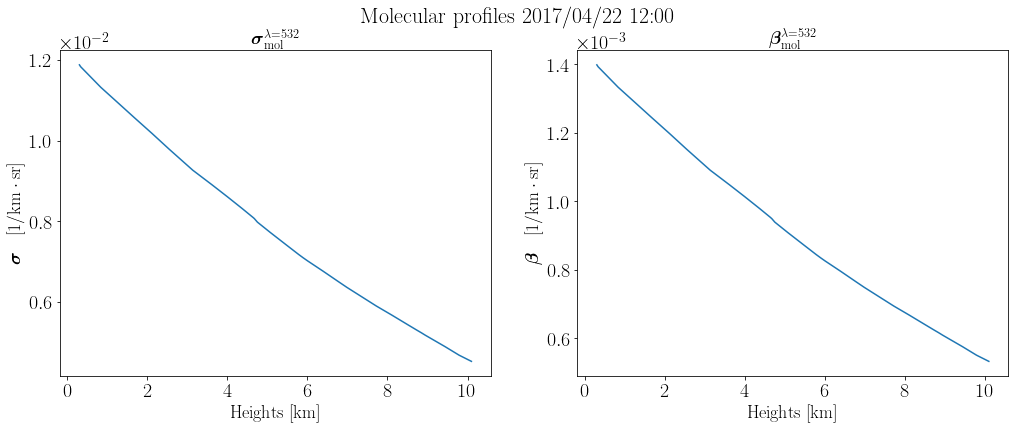

In [43]:
'''Visualize molecular profiles''' 
vis_molecular = True 
save_fig = False
if vis_molecular:
    lData  = {'x':[heights],'y':[sigma_mol],'lableX': 'Heights [km]',
              'lableY': r"$\boldsymbol\sigma\quad[\rm 1/km\cdot sr]$",
              'stitle':r'$\boldsymbol\sigma_{{\rm mol}}^{{\lambda={0:.0f}}}$'.format(lambda_um)}
    rData  = {'x':[heights],'y':[beta_mol],'lableX': 'Heights [km]',
              'lableY': r'$\boldsymbol\beta\quad[\rm{{1}/{km\cdot sr}]}$',
              'stitle':r'$\boldsymbol\beta_{{\rm mol}}^{{\lambda={0:.0f}}}$'.format(lambda_um)}
    stitle= r'Molecular profiles {}'.format(stime)
    [fig, axes] = mscLid.visCurve(lData,rData,stitle)
    plt.show()
    if save_fig:
	    sfname = os.path.join(out_dir,stitle.replace('/','-').replace(':','_')+'.png')
	    print(sfname)
	    fig.savefig(sfname,bbox_inches='tight',dpi=700)

### Lidar Retrievals (from Tropos)
Read Lidar retrievals of Julian, and regenerate lidar measurements 
> ##### Note: this section assumes that the .nc file of the original measurements doesn't exists. 

Time manipulation of lidar's measurements throughout a day.
> E.g. of usage here is for measurements 2017-04-22 06:00:00 - 11:59:30. 6 hours with time resolution of 30 seconds. 

In [44]:
datatime_start = datetime(2017,4,22,0,0)
date_str = datatime_start.strftime('%Y_%m_%d')

In [45]:
retrivals_dir = r'./data examples/lidar retrieval/2017_04_22_Lidar/2017_04_22/'
retrivals_path = retrivals_dir + '*21smooth.txt'
lidar_paths = sorted(glob.glob(retrivals_path))[:4] 
lidar_df = pd.read_csv(lidar_paths[0],delimiter="\t",sep=" ",encoding='unicode_escape', 
		                       skiprows=None)
lidar_df

,Height(km):,Beta355 (Mm^-1 sr^-1):,error beta355 (Mm^-1 sr^-1),Beta532 (Mm^-1 sr^-1):,error beta532 (Mm^-1 sr^-1),Beta1064 (Mm^-1 sr^-1):,error beta1064 (Mm^-1 sr^-1),alpha355 (Mm^-1 sr^-1):,error alpha355 (Mm^-1),alpha532 (Mm^-1 sr^-1):,...,Height NF 355 (km):,Beta355 NF (Mm^-1 sr^-1):,error beta355 NF (Mm^-1 sr^-1),alpha 355 NF (Mm^-1 sr^-1):,error alpha355 NF (Mm^-1),Spar 355 NF (sr):,error Spar 355 NF (sr),BetaMOL 355 (m^-1 sr^-1),BetaMOL 532 (m^-1 sr^-1),BetaMOL 1064 (m^-1 sr^-1)
0,0.115822,-7.310998,0.0,-1.358923,0.0,-0.048960,0.0,-365.549880,0.0,-67.946129,...,0.115822,-2.934704,NaN,-146.735210,0.0,50.0,0.0,0.007569,0.001420,0.000086
1,0.123293,-7.270647,0.0,-1.348471,0.0,-0.040382,0.0,-363.532363,0.0,-67.423567,...,0.123293,-2.509770,NaN,-125.488507,0.0,50.0,0.0,0.007564,0.001419,0.000086
2,0.130765,-7.225339,0.0,-1.336122,0.0,-0.030342,0.0,-361.266934,0.0,-66.806125,...,0.130765,-2.081802,NaN,-104.090075,0.0,50.0,0.0,0.007559,0.001418,0.000086
3,0.138236,-7.173630,0.0,-1.322223,0.0,-0.018973,0.0,-358.681513,0.0,-66.111158,...,0.138236,-1.646046,NaN,-82.302302,0.0,50.0,0.0,0.007555,0.001417,0.000086
4,0.145708,-7.112251,0.0,-1.306397,0.0,-0.006243,0.0,-355.612539,0.0,-65.319866,...,0.145708,-1.181717,NaN,-59.085850,0.0,50.0,0.0,0.007550,0.001416,0.000086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2217,16.680049,-8.547495,0.0,-0.527826,0.0,0.016042,0.0,-427.374775,0.0,-26.391323,...,16.680049,3.943673,NaN,197.183631,0.0,50.0,0.0,0.001088,0.000204,0.000012
2218,16.687521,-9.385577,0.0,-0.985092,0.0,0.044331,0.0,-469.278852,0.0,-49.254587,...,16.687521,2.592197,NaN,129.609863,0.0,50.0,0.0,0.001087,0.000204,0.000012
2219,16.694992,-7.939435,0.0,-0.562321,0.0,0.172943,0.0,-396.971739,0.0,-28.116068,...,16.694992,1.387138,NaN,69.356903,0.0,50.0,0.0,0.001085,0.000204,0.000012
2220,16.702464,-7.627735,0.0,-0.820735,0.0,0.082254,0.0,-381.386764,0.0,-41.036732,...,16.702464,0.469757,NaN,23.487865,0.0,50.0,0.0,0.001084,0.000203,0.000012


### Regenerate Lidar power and the Logarithmic range adjusted power
> Notes:
>   1. The Lidar ratio, $b=55[\rm sr]$, and Lidar factor, $P_0a\frac{c\tau}{2}\approx 1.22+13$,
> were taken from Tropos retrieval of the shown time.
>   2. The Lidar factor, in reality, is not constant, neither known. It changes through time. E.g, it degrades after the change of the lamp,
>and dirt/dust on the covering glass affects as well on it's effective value. 
>Therefore it should be recalculated every time for retrieving profiles. 

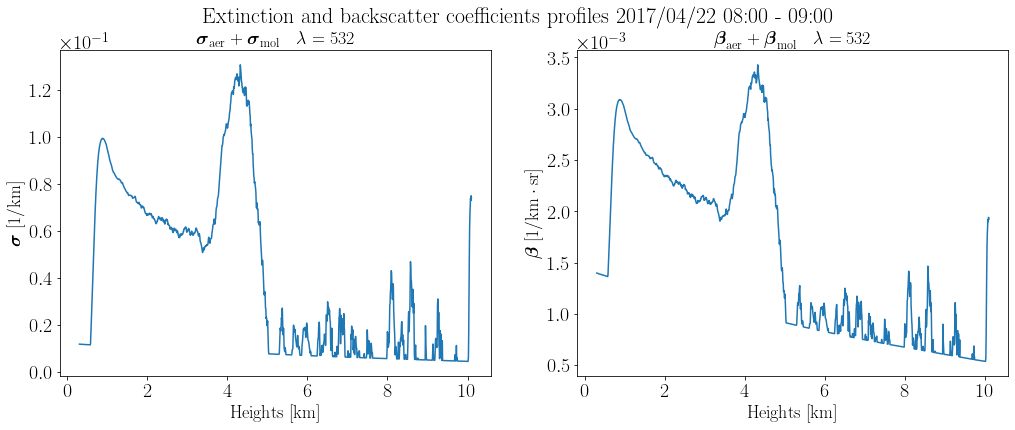

In [46]:
#lambda_um= getattr(LAMBDA, chan)*1e+9
#matplotlib.use('Qt5Agg')
''' Load Lidar profiles from 22/4/17'''
#retrivals_path = "./{}/*21smooth.txt".format(date_str)
lidar_paths = sorted(glob.glob(retrivals_path))[:1] 
profiles_sigma = []
profiles_beta = []
for path in lidar_paths:
    lidar_profile = LidarProfile(path)
    cur_profiles_0 = lidar_profile.interpolate(heights)[0] # TODO: Make sure - non negativity of retrieved values
    cur_profiles_1 = lidar_profile.interpolate(heights)[1] # TODO: Make sure - non negativity of retrieved values
    profiles_sigma.append(cur_profiles_0)
    profiles_beta.append(cur_profiles_1)
    time_stamps = extract_date_time(path,r'-(.*)_(.*)-(.*)-.*.txt', ['%Y%m%d','%H%M','%H%M'])
#time_stamps
stime='{} {} - {}'.format(time_stamps[0].date().__format__('%Y/%m/%d'),
                          time_stamps[1].time().__format__('%H:%M'),
                          time_stamps[2].time().__format__('%H:%M'))

#print(stime)
                        
''' Total profiles values of beta and sigma : molecular + aerosol '''
beta_aer_orig = profiles_beta[0]  # [1/km sr] #>Note: Channels [0] is for 8:00-9:00 
sigma_aer_orig = profiles_sigma[0] # [1/km]
betaT_orig = beta_aer_orig  + beta_mol 
sigmaT_orig = sigma_aer_orig + sigma_mol 
B_0 = 50    # [sr] #Value from Tropos retrieval (S in ...info.txt) - Lidar ratio . The value is taken from -20170422_0800-0900-41smooth-info.txt the lidar ratio for UV,G,IR is 55
b = 1./B_0

'''visualise sigma and molecular'''
vis_orig=True
if vis_orig:
	lData  = {'x':[heights],'y':[sigmaT_orig],'lableX': 'Heights [km]',
	          'lableY': r'$\boldsymbol\sigma\;{\rm [1/km]}$',
	          'stitle':r'$\boldsymbol\sigma_{{\rm aer}}+\boldsymbol\sigma_{{\rm mol}}\quad {{\lambda={0:.0f}}}$'.format(lambda_um)}
	rData  = {'x':[heights],'y':[betaT_orig],'lableX': 'Heights [km]',
	          'lableY': r'$\boldsymbol\beta\;{\rm [1/km \cdot sr]}$',
	          'stitle':r'$\boldsymbol\beta_{{\rm aer}}+\boldsymbol\beta_{{\rm mol}}\quad {{\lambda={0:.0f}}}$'.format(lambda_um)}
	stitle= 'Extinction and backscatter coefficients profiles {}'.format(stime)
	[fig2, axes2] = mscLid.visCurve(lData,rData,stitle)
	plt.show()
	if save_fig: 
		sfname = os.path.join(out_dir,stitle.replace('/','-').replace(':','_')+'.png')
		fig2.savefig(sfname,bbox_inches='tight',dpi=700)

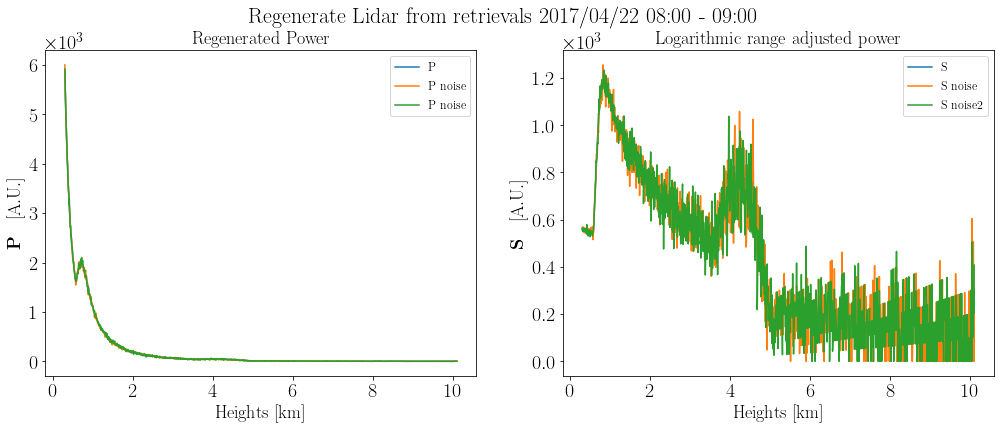

In [47]:
'''Lidar constant. Note that A,P0,tau here are estimated. 
The lidar_const value should be be calculated following Rayleigh fit'''
tau = station.dt # 50e-9 # [sec] temporal pulse width of the lidar
A = 1       # [km]  # TODO : ask for this value 
P0 = 1e+3 #1e+15   # TODO : ask for this value 
lidar_const = 1.219615E+13
# reference heigt was 5-6Km , therefore normalizing lidar const with r^2 for the height of 5.5Km
x = np.abs(heights-5.5)
ref_h = heights[np.where(x==x.min())][0]
norm_val = np.power(1E+3*ref_h,2) # multiplyin with E+3 to convert from km to meters
lidar_const = lidar_const/norm_val #/(40775628)  # The value is from Tropos retrieval (Lidar constants in ...info.txt) # 7.49E+12#  # #lidar_const_optimized #1e+13# lidar_const_optimized#1e+13 #lidar_const_optimized #1e+13 #lidar_const_optimized
'''Calculate the power and the Logarithmic range adjusted power'''
P = mscLid.generate_P(P0,c,A,tau,heights,sigmaT_orig,betaT_orig,lidar_const,add_photon_noise=False) #TODO: Add noise to the signal regeneration.
S = mscLid.calc_S(heights,P)

#Apply photon noise (Poisson statistics)
P_noise = mscLid.generate_P(P0,c,A,tau,heights,sigmaT_orig,betaT_orig,lidar_const)
S_noise = mscLid.calc_S(heights,P_noise)
P_noise2 = mscLid.generate_P(P0,c,A,tau,heights,sigmaT_orig,betaT_orig,lidar_const)
S_noise2 = mscLid.calc_S(heights,P_noise2)

'''Visualize the power and the Logarithmic range adjusted power'''
vis_power=True
if vis_power:
    lData  = {'x':[heights,heights,heights],'y':[P,P_noise,P_noise2],'lableX': 'Heights [km]',
              'lableY': r'$\boldsymbol{\rm P}\quad[\rm A.U.]$',
              'legend': [r'P',r'P noise',r'P noise'],
              'stitle':r'Regenerated Power '}
    rData  = {'x':[heights,heights,heights],'y':[S,S_noise,S_noise2],'lableX': 'Heights [km]',
              'lableY': r'$\boldsymbol{\rm S}\quad[\rm A.U.]$',
              'legend': [r'S',r'S noise',r'S noise2'],
              'stitle':r'Logarithmic range adjusted power'}
    stitle= 'Regenerate Lidar from retrievals {}'.format(stime)
    [fig1, axes1] = mscLid.visCurve(lData,rData,stitle)
    plt.show()
    if save_fig:
	    print(stitle)
	    sfname = os.path.join(out_dir,stitle.replace('/','-').replace(':','_')+'.png')
	    fig1.savefig(sfname,bbox_inches='tight',dpi=700)


In [48]:
#  Add background signal. Ask for common values.
#  What other sources of noise should be incorporated to the signal? electronic?
#  How to introduce geometric and temperature affects on the signal ?

Creating pattern of laser power through days
> The lidar factor is dependent on optical and geometrical values of the system. 
> Since I don't have this information yet I invented a decay pattern curve (according to Zhenping results of lidar factor).
> Then added to it some whiht gaussian noise having variance of 2.5% of pick power (aka P0)  

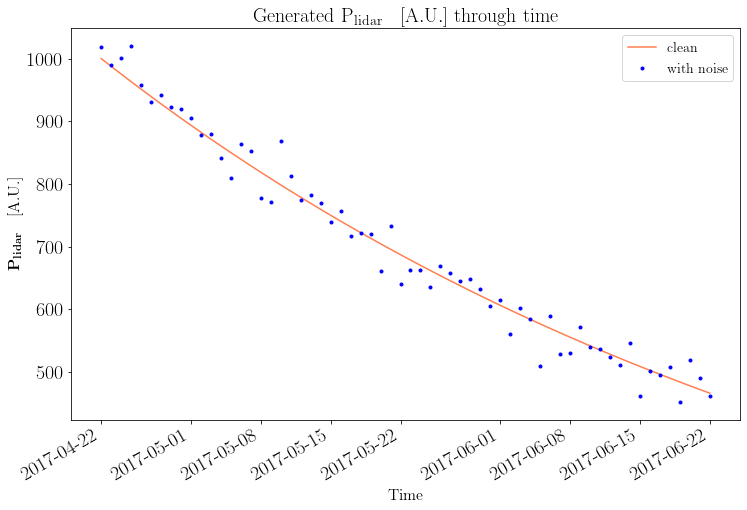

In [49]:
# Creating pattern of laser power through days
#mpld3.enable_notebook()
import matplotlib.dates as mdates
datatime_end_day = datetime(2017,6,22,6,0)

times_days =  mscLid.create_times_list(datatime_start, datatime_end_day, 1, 'days')
t_rate =  80  # The rate of power decay [days]
t_days = np.array([day[0] for day in enumerate(times_days)])

'''
An arbitrary function representing the decay of the lidar, according to t_rate (the decay rate) in days
'''
P_t = lambda t: P0*(np.exp(-t_days/t_rate))

powers = P_t(t_days)
dP = P0*.025
rand_p = np.random.normal(0,dP,t_days.size)
pores_noisy = powers+rand_p

# plotting lidar power through days
vis_power_new=True
if vis_power_new:
	fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(12, 8))
	fig.autofmt_xdate()
	plt.plot(times_days,powers,color='coral',label='clean')
	plt.plot(times_days,pores_noisy,'b.',label='with noise')
	xfmt = mdates.DateFormatter('%Y-%m-%d')
	ax.legend(fontsize = 14)
	ax.xaxis.set_major_formatter(xfmt)
	ax.set_xlabel('Time',fontsize = 16,fontweight='bold')
	ax.set_ylabel(r'$\boldsymbol{\rm P_{lidar}}\quad[\rm A.U.]$',fontsize = 16,fontweight='bold')
	stitle = r'Generated ${\rm P_{lidar}\quad[\rm A.U.]}$ through time'
	ax.set_title(stitle,fontsize=20, fontweight='bold')
	plt.rc('xtick',labelsize =12)
	plt.rc('ytick',labelsize=16)
	fig.set_constrained_layout = True
	plt.show()
	
	save_fig = False
	if save_fig:
		stitle ='Generated P lidar through time'
		sfname = os.path.join(out_dir,stitle.replace('/','-').replace(':','_')+'.png')
		#print(sfname)
		fig.savefig(sfname,bbox_inches='tight',dpi=700)

# TODO: expend values to a full year, as concatenated cycles of the lamp .

Creating an atmosphere

In [50]:
from pytictoc import TicToc
ticker = TicToc()

import numpy.matlib as matlib
datatime_start = datetime(2017,4,22,0,0,0)
datatime_end = datetime(2017,4,22,23,59,30)
delta_t = 30 # [seconds]
times_seconds = mscLid.create_times_list(datatime_start, datatime_end, delta_t, 'seconds')
t_sec = np.array([sec[0] for sec in enumerate(times_seconds)])
times_str = [time.strftime('%H:%M:%S') for time in times_seconds]
#heights[1316]
heights

array([ 0.30775  ,  0.3152461,  0.3227422, ..., 10.0826644, 10.0901605,
       10.0976566])

In [51]:
# constant init for P
#P_noise = mscLid.generate_P(P0,c,A,tau,heights,sigmaT_orig,betaT_orig,lidar_const)
sigmaT_day = np.tile(sigmaT_orig.reshape(n,1),len(times_seconds))
betaT_day = np.tile(betaT_orig.reshape(n,1),len(times_seconds))
ticker.tic()
P_day_clean = mscLid.generate_P(P0,c,A,tau,heights,sigmaT_day,betaT_day,lidar_const,False)
ticker.toc()
ticker.tic()
P_day = mscLid.generate_P(P0,c,A,tau,heights,sigmaT_day,betaT_day,lidar_const,True)
ticker.toc()
print('hello2')

Elapsed time is 0.478058 seconds.
Elapsed time is 0.640149 seconds.
hello2


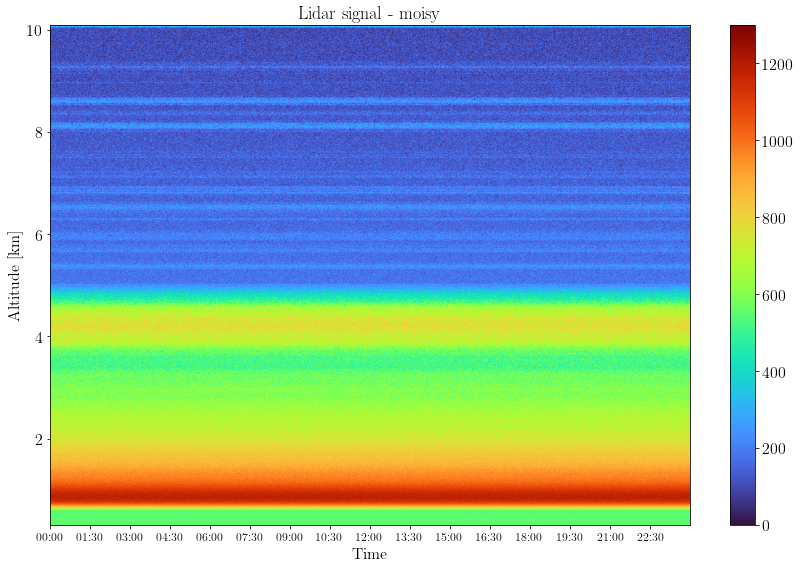

In [52]:
# creating the range corrected signal S(r) = ln(r^2*P(r))
S_clean = mscLid.calc_S(heights,P_day_clean)
S = mscLid.calc_S(heights,P_day)
P_diff = P_day-P_day_clean
S = mscLid.calc_S(heights,P_day_clean)
S_diff = mscLid.calc_S(heights,P_diff)
Pr2= np.matmul(np.diag(np.power(heights, 2)),P_day)
vis_power_new=True
if vis_power_new:
	fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(12, 8))
	x_lims = [times_seconds[0],times_seconds[-1]]
	x_lims = mdates.date2num(x_lims)
	y_lims = [heights[0],heights[-1]]
	im = ax.imshow(Pr2,extent= [x_lims[0],x_lims[1],y_lims[-1],y_lims[0]]
	               ,aspect='auto', cmap = 'turbo')#')#nipy_spectral')
	ax.invert_yaxis()
	ax.xaxis_date()
	ax.get_xaxis().set_major_locator(mdates.MinuteLocator(interval=90))
	xfmt = mdates.DateFormatter('%H:%M')
	ax.xaxis.set_major_formatter(xfmt)
	ax.set_ylabel('Altitude [km]',fontsize =16)
	ax.set_xlabel('Time',fontsize =16)
	stitle = 'Lidar signal - moisy '
	ax.set_title(stitle,fontsize =18)
	plt.rc('xtick',labelsize =12)
	plt.rc('ytick',labelsize=16)
	fig.colorbar(im, ax=ax)
	fig.tight_layout()
	plt.show()
	
	save_fig= False
	if save_fig:
		sfname = os.path.join(out_dir,stitle.replace('/','-').replace(':','_')+'.png')
		#print(sfname)
		fig.savefig(sfname,bbox_inches='tight',dpi=700)



 Creating BG noise 2

In [53]:
'''
TODO: 
1. background noise :
    - add background noise the lidar signal according the appropriate times (e.g. 06:00-11:59)
	- create module of bg noise
	- Note: the parameters of the gaussian curve should variate during the year . e.g. the width 
	of the Gaussain lobe shrinks during spring-winter and extends during spring-summer
	TODO: use Astral package to calculate sunrise, sunset an middday hours according to Haifa location and date
	- compare photon count and bg noise to Birgit output from raw data (Matlab scripts)
	- update code for data frames only (both measur and estimated)
2. photon noise: 
	- make sure each measurment is generated with a new photon noise 
	- Add height dependent noise
	- set random seed - check about this issue  
	- add photon noise to P generator , with flag :'poiss_noise=True'
3. Visualizing S:
	- Show S for 3 channels 
	- create a plot function for image . add channel and date in the title

4. change profiles: 
	- change 5% of lidar ratio through 6 hours
	- interpolate 2 Gdas file to get a change in the molecular profile
	- apply gausian on the image
	-  interpolate profiles retreived from julian 8:00, 9:00, 10:00, 11:00 etc
5. change sampling of P_const through the day 
6. create a plot function for image . add channel and date in the title

'''


"\nTODO: \n1. background noise :\n    - add background noise the lidar signal according the appropriate times (e.g. 06:00-11:59)\n\t- create module of bg noise\n\t- Note: the parameters of the gaussian curve should variate during the year . e.g. the width \n\tof the Gaussain lobe shrinks during spring-winter and extends during spring-summer\n\tTODO: use Astral package to calculate sunrise, sunset an middday hours according to Haifa location and date\n\t- compare photon count and bg noise to Birgit output from raw data (Matlab scripts)\n\t- update code for data frames only (both measur and estimated)\n2. photon noise: \n\t- make sure each measurment is generated with a new photon noise \n\t- Add height dependent noise\n\t- set random seed - check about this issue  \n\t- add photon noise to P generator , with flag :'poiss_noise=True'\n3. Visualizing S:\n\t- Show S for 3 channels \n\t- create a plot function for image . add channel and date in the title\n\n4. change profiles: \n\t- change

In [54]:
channels =['UV','G','IR']
bg_signal_folder = os.path.join(os.getcwd(),'background_signal')
'''Load samples of the plots in the original image: '''
bg_meas_path = os.path.join(bg_signal_folder,'bg_signal_measurments.csv')#'high_blue_meas.csv'
bg_meas_df = pd.read_csv(bg_meas_path, delimiter=",",sep="\t",
                         encoding='unicode_escape', skiprows=None,parse_dates=True)
bg_meas_df

,UV_high_times,UV_high_vals,UV_low_times,UV_low_vals,G_high_times,G_high_vals,G_low_times,G_low_vals,IR_high_times,IR_high_vals,IR_low_times,IR_low_vals
0,11/8/2020 0:10,0.06003,11/8/2020 0:02,0.00501,11/8/2020 0:01,0.03001,11/8/2020 0:03,0.00124,11/8/2020 0:03,0.03751,11/8/2020 23:58,0.00900
1,11/8/2020 0:30,0.05759,11/8/2020 1:00,0.00267,11/8/2020 0:31,0.03259,11/8/2020 0:40,0.00228,11/8/2020 0:18,0.06255,11/8/2020 23:02,0.00634
2,11/8/2020 0:52,0.03015,11/8/2020 2:00,0.00284,11/8/2020 1:16,0.03522,11/8/2020 1:04,0.00090,11/8/2020 0:24,0.03757,11/8/2020 22:45,0.00880
3,11/8/2020 1:17,0.05522,11/8/2020 2:33,0.00293,11/8/2020 2:22,0.03040,11/8/2020 1:29,0.00076,11/8/2020 1:12,0.03521,11/8/2020 22:18,0.00372
4,11/8/2020 1:35,0.03277,11/8/2020 3:24,0.01307,11/8/2020 3:18,0.04306,11/8/2020 1:59,0.00184,11/8/2020 1:22,0.06023,11/8/2020 22:01,0.00867
...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11/8/2020 22:28,0.06625,NaN,NaN
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11/8/2020 22:41,0.03629,NaN,NaN
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11/8/2020 23:11,0.06887,NaN,NaN
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11/8/2020 23:44,0.06146,NaN,NaN


In [55]:
'''Load parameters of gaussian curve fit:'''
bg_params_path = os.path.join(bg_signal_folder,'curve_params.yml')
with open(bg_params_path,'r') as ymlfile:
        params = yaml.safe_load(ymlfile)

df_params =  pd.DataFrame()
for chan in channels:
	resh = pd.DataFrame.from_dict(params[chan]['high'],orient='index',columns=['{}_high'.format(chan)])
	resl = pd.DataFrame.from_dict(params[chan]['low'],orient='index',columns=['{}_low'.format(chan)])
	df_params[resh.columns]= resh
	df_params[resl.columns]= resl
df_params= df_params.T

In [56]:
'''Functions of calculating bg signal using pandas data frame'''

def calc_curve_df(row,t,bins_ratio):
    return mscLid.calc_gauss_curve(t,row['A'],row['H'],bins_ratio*row['t0'],bins_ratio*row['W'])

def create_bg_df(df_params,datatime_start=None,datatime_end=None,delta_t=30,delta_t_type ='seconds',t=None,n_source_bins=864):

	'''Creating 24 hrs of measuring points (indicator and time stamp for each'''
	if (datatime_start is None) or (datatime_start is None):
		cur_date = datetime.now().date()
		datatime_start = datetime.combine(cur_date,datetime.min.time())
		datatime_end = datetime.combine(cur_date,datetime.max.time())
	df_curves = pd.DataFrame({'Time':pd.date_range(start=datatime_start,end= datatime_end, freq='30S')})
	#t_times = mscLid.create_times_list(datatime_start, datatime_end, delta_t, delta_t_type)
	bins_per_day = df_curves.size
	#print('bins',bins_per_day)#len(t_times)
	if t is None:
		t = np.arange(0,bins_per_day)
	bins_ratio = bins_per_day/n_source_bins

	'''Generating data frame of bg curves'''
	#print('df_curves.cols ',df_curves.columns)
	res = df_params.apply(calc_curve_df, axis=1, result_type='expand',args=(t,bins_ratio,)).T
	df_curves[res.columns]=res
	#print('res.cols ',res.columns)
	#print('df_curves.cols ',df_curves.columns)
	#df_curves.insert(0, 'Time',t_times)

	'''calc mean & std curves for each channel'''
	print (df_curves)
	for chan in ['UV','G','IR']:
		res = df_curves.apply(calc_curve_stats_df,1,args=(chan,bins_per_day,),result_type='expand')
		df_curves[res.columns]=res
		print (res)
	''' create new bg signal'''
	for chan in ['UV','G','IR']:
		tmp_col = '{}_rand'.format(chan)
		# creating ranom numbers to multiply with std values , then this collumn will be removed
		# This tric should be faster and is replacing the following (when using for loop on liasy that contains nd-array in each cell):
		# bg_new_chan = mean_val.reshape(bins_per_day,1)+\
        #         np.matmul(np.diagflat(std_val),np.random.randn(bins_per_day,1))
		rand = pd.DataFrame({'{}_rand'.format(chan):np.random.randn(bins_per_day,1).flatten()})
		df_curves[rand.columns]=rand
		res = df_curves.apply(calc_new_bg,1,args=(chan,bins_per_day,),result_type='expand')
		df_curves[res.columns]=res
		df_curves= df_curves.drop(tmp_col, axis=1)

	#df_curves[sorted(df_curves.columns)]
	return df_curves

def calc_curve_stats_df(col,chan='UV',bins_per_day=2880):
	low_val = col['{}_low'.format(chan)]
	#print(type(low_val),'check')
	high_val = col['{}_high'.format(chan)]
	mean_val = 0.5*(low_val+high_val)
	std_val = 0.25*(high_val-low_val)
	return pd.Series([mean_val,std_val],index=['{}_mean'.format(chan),'{}_std'.format(chan)])

def calc_new_bg(col,chan='UV',bins_per_day=2880):
	mean_val = col['{}_mean'.format(chan)]
	std_val = col['{}_std'.format(chan)]
	rand_val = col['{}_rand'.format(chan)]
	new_val = mean_val+ rand_val*std_val
	return pd.Series([new_val],index=['{}_new'.format(chan)])
	#print('std',tmp)

	return res

In [57]:
'''Calculate bg signal data frame'''
datatime_start = datetime(2017,4,22,0,0)
datatime_end = datetime(2017,4,22,23,59,30)
df_curves = create_bg_df(df_params, datatime_start,datatime_end,n_source_bins=864)
#df_curves


                    Time   UV_high    UV_low    G_high     G_low   IR_high  \
0    2017-04-22 00:00:00  0.043277  0.002567  0.053641  0.005864  0.057376   
1    2017-04-22 00:00:30  0.043381  0.002593  0.053781  0.005918  0.057460   
2    2017-04-22 00:01:00  0.043485  0.002619  0.053923  0.005973  0.057545   
3    2017-04-22 00:01:30  0.043590  0.002645  0.054065  0.006027  0.057630   
4    2017-04-22 00:02:00  0.043696  0.002671  0.054209  0.006083  0.057716   
...                  ...       ...       ...       ...       ...       ...   
2875 2017-04-22 23:57:30  0.030041  0.000101  0.035072  0.000105  0.045247   
2876 2017-04-22 23:58:00  0.030040  0.000101  0.035071  0.000105  0.045245   
2877 2017-04-22 23:58:30  0.030040  0.000101  0.035070  0.000105  0.045242   
2878 2017-04-22 23:59:00  0.030039  0.000101  0.035069  0.000105  0.045240   
2879 2017-04-22 23:59:30  0.030039  0.000101  0.035069  0.000105  0.045238   

        IR_low  
0     0.002583  
1     0.002603  
2     0.0026

In [58]:
'''Calculate bg signal data frame'''
datatime_start = datetime(2017,4,22,0,0)
datatime_end = datetime(2017,4,22,23,59,30)
df_curves = create_bg_df(df_params, datatime_start,datatime_end,n_source_bins=864)
#df_curves


                    Time   UV_high    UV_low    G_high     G_low   IR_high  \
0    2017-04-22 00:00:00  0.043277  0.002567  0.053641  0.005864  0.057376   
1    2017-04-22 00:00:30  0.043381  0.002593  0.053781  0.005918  0.057460   
2    2017-04-22 00:01:00  0.043485  0.002619  0.053923  0.005973  0.057545   
3    2017-04-22 00:01:30  0.043590  0.002645  0.054065  0.006027  0.057630   
4    2017-04-22 00:02:00  0.043696  0.002671  0.054209  0.006083  0.057716   
...                  ...       ...       ...       ...       ...       ...   
2875 2017-04-22 23:57:30  0.030041  0.000101  0.035072  0.000105  0.045247   
2876 2017-04-22 23:58:00  0.030040  0.000101  0.035071  0.000105  0.045245   
2877 2017-04-22 23:58:30  0.030040  0.000101  0.035070  0.000105  0.045242   
2878 2017-04-22 23:59:00  0.030039  0.000101  0.035069  0.000105  0.045240   
2879 2017-04-22 23:59:30  0.030039  0.000101  0.035069  0.000105  0.045238   

        IR_low  
0     0.002583  
1     0.002603  
2     0.0026

In [59]:
'''Calculate bg signal data frame'''
datatime_start = datetime(2017,4,22,0,0)
datatime_end = datetime(2017,4,22,23,59,30)
df_curves = create_bg_df(df_params, datatime_start,datatime_end,n_source_bins=864)
#df_curves


                    Time   UV_high    UV_low    G_high     G_low   IR_high  \
0    2017-04-22 00:00:00  0.043277  0.002567  0.053641  0.005864  0.057376   
1    2017-04-22 00:00:30  0.043381  0.002593  0.053781  0.005918  0.057460   
2    2017-04-22 00:01:00  0.043485  0.002619  0.053923  0.005973  0.057545   
3    2017-04-22 00:01:30  0.043590  0.002645  0.054065  0.006027  0.057630   
4    2017-04-22 00:02:00  0.043696  0.002671  0.054209  0.006083  0.057716   
...                  ...       ...       ...       ...       ...       ...   
2875 2017-04-22 23:57:30  0.030041  0.000101  0.035072  0.000105  0.045247   
2876 2017-04-22 23:58:00  0.030040  0.000101  0.035071  0.000105  0.045245   
2877 2017-04-22 23:58:30  0.030040  0.000101  0.035070  0.000105  0.045242   
2878 2017-04-22 23:59:00  0.030039  0.000101  0.035069  0.000105  0.045240   
2879 2017-04-22 23:59:30  0.030039  0.000101  0.035069  0.000105  0.045238   

        IR_low  
0     0.002583  
1     0.002603  
2     0.0026

In [60]:
'''Calculate bg signal data frame'''
datatime_start = datetime(2017,4,22,0,0)
datatime_end = datetime(2017,4,22,23,59,30)
df_curves = create_bg_df(df_params, datatime_start,datatime_end,n_source_bins=864)
#df_curves


                    Time   UV_high    UV_low    G_high     G_low   IR_high  \
0    2017-04-22 00:00:00  0.043277  0.002567  0.053641  0.005864  0.057376   
1    2017-04-22 00:00:30  0.043381  0.002593  0.053781  0.005918  0.057460   
2    2017-04-22 00:01:00  0.043485  0.002619  0.053923  0.005973  0.057545   
3    2017-04-22 00:01:30  0.043590  0.002645  0.054065  0.006027  0.057630   
4    2017-04-22 00:02:00  0.043696  0.002671  0.054209  0.006083  0.057716   
...                  ...       ...       ...       ...       ...       ...   
2875 2017-04-22 23:57:30  0.030041  0.000101  0.035072  0.000105  0.045247   
2876 2017-04-22 23:58:00  0.030040  0.000101  0.035071  0.000105  0.045245   
2877 2017-04-22 23:58:30  0.030040  0.000101  0.035070  0.000105  0.045242   
2878 2017-04-22 23:59:00  0.030039  0.000101  0.035069  0.000105  0.045240   
2879 2017-04-22 23:59:30  0.030039  0.000101  0.035069  0.000105  0.045238   

        IR_low  
0     0.002583  
1     0.002603  
2     0.0026

C:\Users\addalin\.conda\envs\lidar\lib\site-packages\pandas\plotting\_matplotlib\core.py:584: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000024C52F8CC40> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
C:\Users\addalin\.conda\envs\lidar\lib\site-packages\pandas\plotting\_matplotlib\core.py:584: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000024C57E45820> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
C:\Users\addalin\.conda\envs\lidar\lib\site-packages\pandas\plotting\_matplotlib\core.py:584: UserWarning: The handle <matplotlib.lines.Line2D object at 0x0000024C52C13B20> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)
C:\Users\addalin\.conda\envs\lidar\lib\site-packages\pandas\plotting\_matplotlib\c

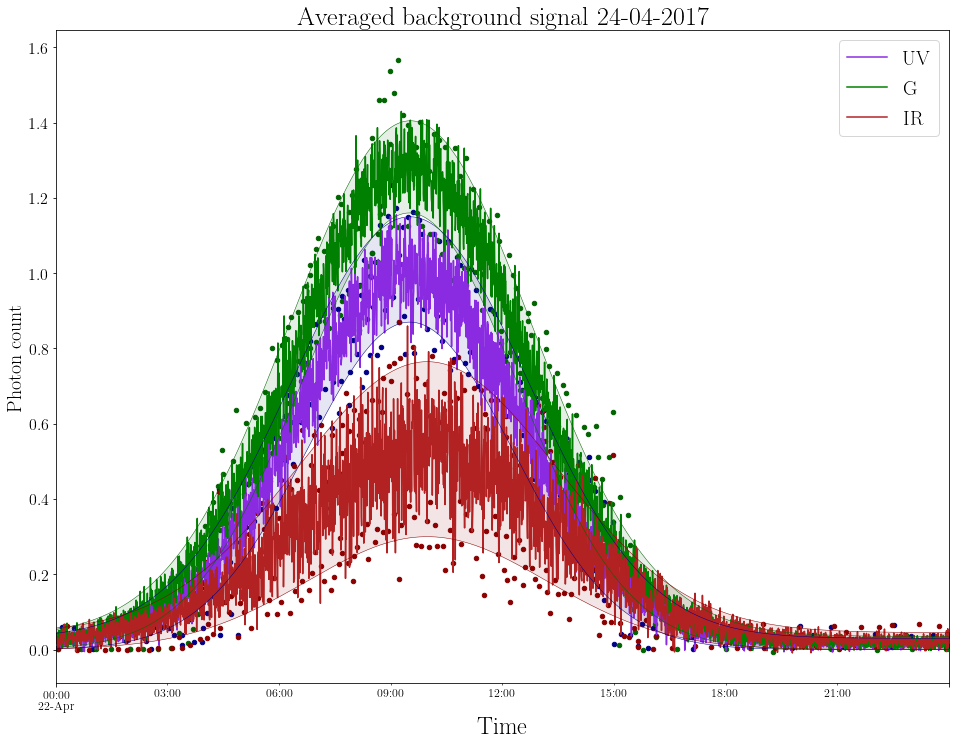

In [61]:
'''Plot bg signal'''
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(16, 12))
df_curves.rename(columns={'UV_new':'UV','G_new':'G','IR_new':'IR'}, inplace=True) #Because of LaTex issues, changin columns names,
df_curves.plot(x='Time',y=['UV','G','IR'],ax=ax,color=['blueviolet','green','firebrick'])

'''Plot high/low bounding curves'''
c_bound = ['darkblue','darkgreen','darkred']
for chan,c in zip(['UV','G','IR'],c_bound):
	df_curves.plot(x='Time',y=['{}_low'.format(chan),'{}_high'.format(chan)],
                ax=ax,color=[c,c,], label=['_nolegend_','_nolegend_',],linewidth=0.5)
	ax.fill_between(df_curves.Time.values,df_curves['{}_high'.format(chan)].values,
	                df_curves['{}_low'.format(chan)].values,facecolor=c, alpha=0.1)
	for cur in ['high','low']:
		cur_df = bg_meas_df[['{}_{}_times'.format(chan,cur),'{}_{}_vals'.format(chan,cur)]].dropna()
		cur_df.rename(columns={'{}_{}_times'.format(chan,cur):'Time','{}_{}_vals'.format(chan,cur):'vals'}, inplace=True)

		cur_df.Time = pd.to_datetime(cur_df.Time, format='%m/%d/%Y %H:%M')
		cur_df.Time=cur_df.Time.apply(lambda dt: dt.replace(year=datatime_start.year,
								month= datatime_start.month, day= datatime_start.day))
		cur_df.plot.scatter(x='Time',y='vals',ax=ax,color=c)


stitle = 'Averaged background signal 24-04-2017'
ax.set_title(stitle,fontsize =26,fontweight='bold')
ax.set_xlabel('Time',fontsize =24,fontweight='bold')
ax.set_ylabel('Photon count',fontsize =20,fontweight='bold')
plt.rc('xtick',labelsize =20)
plt.rc('ytick',labelsize=20)
legend_properties = {'weight':'bold','size':20} #,'edgecolor':0}
ax.legend(prop= legend_properties)#fontsize=14)
fig.set_constrained_layout = True
plt.show()

In [62]:
'''
TODO:
1. add bg image to green chane;
2. Show 3 images : bg, noisy=lidar_n+bg, noisy-clean (range corrected )
3. interpolate profile through the day

1. add scatter plot of original sampels to the new bg signal
2. 2D image of GDAS during the day
3. Interpolating GDAS from measurments every 3 hours

1. 2D images of aerosols extinction and bakscatter durring the day
2. Show backscatter and extiction profiles according hours befor interpolation
3. Choose P_lidar from the relevant measurmnet day

??. create a function depandent on temparture in order to change P_lidar during the day in about 10%
'''

'\nTODO:\n1. add bg image to green chane;\n2. Show 3 images : bg, noisy=lidar_n+bg, noisy-clean (range corrected )\n3. interpolate profile through the day\n\n1. add scatter plot of original sampels to the new bg signal\n2. 2D image of GDAS during the day\n3. Interpolating GDAS from measurments every 3 hours\n\n1. 2D images of aerosols extinction and bakscatter durring the day\n2. Show backscatter and extiction profiles according hours befor interpolation\n3. Choose P_lidar from the relevant measurmnet day\n\n??. create a function depandent on temparture in order to change P_lidar during the day in about 10%\n'